In [101]:
import os
import csv
import cv2
import time
import gc
import matplotlib.pyplot    as plt
import numpy                as np
import plotly.graph_objects as go
from scipy.stats        import skew, kurtosis
from scipy.ndimage      import convolve
from scipy.interpolate  import interp1d


In [102]:
#vars
name, heights, convolved_heights, intensity, x_to_i, i_to_x, y_to_i, i_to_y, sectioned = 0,1,2,3,4,5,6,7,8

window_height = 10

plot_clouds = False
plot_cluster_1 = True
plot_cluster_2 = True

In [103]:
#functions
def get_vectors(data, y_span=window_height):
    vectors = []  
    start_time = time.perf_counter()

    def log(message):
        elapsed = time.perf_counter() - start_time
        print(f"[{elapsed:.6f}s] {message}")
    gc.disable()

    for point_cloud in data:
        start_time = time.perf_counter()
        
        cloud = point_cloud[heights]
        convolved_cloud = point_cloud[convolved_heights]
        
        y_to_i_list = point_cloud[y_to_i]
        y_indices = [y_to_i_list[value] for value in y_to_i_list.keys() if abs(value) <= y_span]

        for i in range(cloud.shape[1]):
            distribution = cloud[y_indices, i]
            convolved_distribution = convolved_cloud[y_indices, i]

            properties = get_props(distribution)
            convolved_properties = get_props_convolved(convolved_distribution)

            vector = convolved_properties + properties

            if not np.any(np.isnan(vector)):
                vectors.append(vector)
        log(f"{point_cloud[0]} vectors added")    
    gc.enable()

    return vectors

def get_props_convolved(distribution):
    properties = []

    mean = np.sqrt(np.mean(distribution))
    max = np.sqrt(np.max(distribution))

    properties.append(mean)
    properties.append(max)

    return properties

def get_props(distribution):
    properties = []
    return_properties = []

    variance =  np.var(distribution) * ((10/window_height)**2)
    skw = skew(distribution)
    kurt = kurtosis(distribution)

    
    properties.append(variance)
    properties.append(skw)
    properties.append(kurt)

    norm = np.linalg.norm(properties)
    
    if norm > 0:
        properties = [x / norm for x in properties]

    z = properties[0]

    return_properties.append(properties[1])
    return_properties.append(np.arccos(z)/(np.pi/2))

    return return_properties

def interpolate_x(table_file,lidar_file):
    with open(table_file) as file:
        lines = file.readlines()

        positions = []
        table_timestamps = []

        char = '-'

        for line in lines:
            if ("+") in line:
                char = '+'
            time = line.split('T')[1]
            x = float(line.split(',')[0])
            parts = time.split(':')
            t = float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2].split(char)[0]) 
            positions.append(x)
            table_timestamps.append(t)

    ordered_positions = []
    ordered_timestamps = []
    if char == '-':
        for i in range(len(positions)-1):
            if positions[i + 1] < positions[i]:
                ordered_positions.append(positions[i])
                ordered_timestamps.append(table_timestamps[i])

    if char == '+':
         for i in range(len(positions)-1):
            if positions[i + 1] > positions[i]:
                ordered_positions.append(positions[i])
                ordered_timestamps.append(table_timestamps[i])


    with open(lidar_file) as file:
        lines = file.readlines()

        lidar_timestamps = []

        time = lines[0].split('T')[1]
        parts = time.split(':')
        min_t = float(parts[1]) * 60  + float(parts[0]) * 3600 + float(parts[2].split(char)[0]) 

        for line in lines:
            time = line.split('T')[1]
            parts = time.split(':')
            t = float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2].split(char)[0]) - min_t
            lidar_timestamps.append(t)


    lidar_timestamps = np.array(lidar_timestamps)
    lidar_timestamps_rounded = np.round(lidar_timestamps/0.02)*0.02
    ordered_timestamps = np.array(ordered_timestamps)[::-1]
    ordered_timestamps -= min_t
    ordered_positions = ordered_positions[::-1]

    ordered_timestamps = np.concatenate([ordered_timestamps[:2], ordered_timestamps[-2:]])
    ordered_positions = np.concatenate([ordered_positions[:2], ordered_positions[-2:]])

    interp_func = interp1d(ordered_timestamps, ordered_positions, kind="linear", fill_value=(ordered_positions[-1], ordered_positions[0]), bounds_error=False) 

    interpolated = interp_func(lidar_timestamps)
            
    return interpolated

def get_point_cloud(paths, y_window = window_height + 5, upsample_ratio = 2):
    print("loading",end = "... ")

    x_start = 5000
    x_stop = 0

    with open(paths[1]) as file:
            lines = file.readlines()
            for line in lines:
                if "XRAY_DPP[Acquisition]#0.X.Start:" in line:
                    x_start = (float)(line.split("XRAY_DPP[Acquisition]#0.X.Start:")[1].strip())
                if "XRAY_DPP[Acquisition]#0.X.Stop:" in line:
                    x_stop = (float)(line.split("XRAY_DPP[Acquisition]#0.X.Stop:")[1].strip())
                if "XRAY_DPP[Acquisition]#0.Y.Start:" in line:
                    y_offset = (float)(line.split("XRAY_DPP[Acquisition]#0.Y.Start:")[1].strip())
                    print(f"y_offset: {y_offset}")

    with open(paths[2]) as file:
        lines = file.readlines()
        transformation_matrix = np.array([list(map(float, line.strip().split(","))) for line in lines])

    imread = lambda fn: cv2.imread(fn, cv2.IMREAD_ANYDEPTH)
    
    point_cloud  = np.fromfile(paths[3], dtype=np.float32).reshape(-1, 3) 

    #interpolated_x = interpolate_x(paths[5],paths[6])
    #interpolated_x = np.repeat(interpolated_x, len(np.unique(point_cloud[:, 1])))

    #point_cloud[:,0] = interpolated_x

    intensity_map = imread(paths[4])
    
    print(f"{paths[0]} loaded, {point_cloud.shape[0]} points")
    print("trimming",end = "... ")
    
    intensity_values = np.reshape(intensity_map, (-1, 1))
    intensity_cloud = np.hstack((point_cloud[:,:2], intensity_values))

    point_cloud = (np.hstack((point_cloud, np.ones((point_cloud.shape[0], 1)))) @ transformation_matrix.T)[:,:3]
    intensity_cloud = (np.hstack((intensity_cloud, np.ones((intensity_cloud.shape[0], 1)))) @ transformation_matrix.T)[:,:3]

    mask = (point_cloud[:,0] <= x_start) & (point_cloud[:,0] >= x_stop) & ((np.abs(point_cloud[:,1])) <= y_window)
    point_cloud = point_cloud[mask]
    intensity_cloud = intensity_cloud[mask]

    min_intensity = np.nanmax(intensity_cloud[:,2])
    min_z = np.nanmax(point_cloud[:,2])
    
    print(f"trimmed to {point_cloud.shape[0]} points")

    print("converting to arrays",end = "... ")

    minimum_x = point_cloud[np.argmin(np.abs(point_cloud[:,0] - x_stop)),0]

    point_cloud[:,0] -= minimum_x
    intensity_cloud[:,0] -= minimum_x
    
    x_values = np.unique(point_cloud[:,0])
    y_values = np.unique(point_cloud[:,1]) 

    x_range = len(x_values)

    if upsample_ratio > 1:
        index_step = (np.nanmean(np.diff(x_values))) / upsample_ratio 
        index_steps = np.arange(int(round(np.nanmax(x_values)/index_step))+1) * index_step

        x_range = len(index_steps)
        x_value_dict = {x: np.argmin(np.abs(index_steps - x)) for x in x_values}
        known_indices = list(x_value_dict.values())
        known_x_values = np.array(list(x_value_dict.keys()), dtype=float)
        all_indices = np.arange(x_range)

        interp_func = interp1d(known_indices, known_x_values, kind="linear", fill_value="extrapolate")
        x_values = interp_func(all_indices)
    
    x_value_dict = {x: index for index,x in enumerate(x_values)}
    y_value_dict = {y: index for index,y in enumerate(y_values)}

    point_array = np.full((len(y_values), x_range),np.nan)
    intensity_array = np.full((len(y_values), x_range),np.nan)
    point_dictionary = {(row[0],row[1]): (index, row[2]) for index,row in enumerate(point_cloud)}
    intensity_dictionary = {(row[0],row[1]): (index, row[2]) for index,row in enumerate(intensity_cloud)}

    for x in range (x_range):
        for y in range (len(y_values)):
            x_val = x_values[x]
            y_val = y_values[y]

            point_z = point_dictionary.get((x_val,y_val))
            intensity_z = intensity_dictionary.get((x_val,y_val))

            if point_z is not None:
                point_array[y,x] = point_z[1]
            else:
                point_array[y,x] = min_z
            if intensity_z is not None:
                intensity_array[y,x] = intensity_z[1]
            else:
                intensity_array[y,x] = min_intensity

    print(f"arrays built")
    if upsample_ratio > 1:
        print("upsampling",end = "... ")

        for y in range(len(y_values)):

            interpolated_z_values= []
            interpolated_i_values = []

            for dy in [-1,0,1]:
                y_dy = y + dy
                if (y_dy >= 0) & (y_dy < len(y_values)):
                    known_z = point_array[y_dy,known_indices]
                    known_i = intensity_array[y_dy,known_indices]
                    known_x = x_values[known_indices]
                    mask = ~np.isnan(known_z)
                    z_interp = interp1d(known_x[mask], known_z[mask], kind='linear', fill_value="extrapolate")
                    i_interp = interp1d(known_x[mask], known_i[mask], kind='linear', fill_value="extrapolate")

                    interpolated_z_values.append(z_interp(x_values))
                    interpolated_i_values.append(i_interp(x_values))

            point_array[y, :] = np.mean(interpolated_z_values, axis=0)
            intensity_array[y, :] = np.mean(interpolated_i_values, axis=0)
    
    intensity_array = np.log(np.abs(intensity_array))
    kernel_y = np.array([[-1],[-2],[0],[2],[1]])
    convolved_array = np.abs(convolve(point_array,kernel_y))

    print(f"upsampled to {point_array.size} points")
    print(f"{paths[0]} finished \n")

    return [paths[0],point_array, convolved_array, intensity_array, x_value_dict, x_values, y_value_dict, y_values]

In [104]:
#define parsers
class MacassaFileParser:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.box_folders = []

    def find_folders(self):
        for root, dirs, files in os.walk(self.root_dir):
                for dir_name in dirs:
                    for i in range(10,11):
                        if dir_name.startswith(f"AdaptiveZ_{i}mm"):
                            folder = os.path.join(root, dir_name)
                            if os.path.isdir(folder): 
                                for part_folder in os.listdir(folder):
                                    part_folder = os.path.join(dir_name,part_folder)
                                    full_part_path = os.path.join(root, part_folder)
                                    if os.path.isdir(full_part_path) and "Part" in part_folder:
                                        component_parameters_path = None
                                        lidar2xrf_path = None
                                        bpc_path = None
                                        intensity_path = None
                                        real_dbg_path = None
                                        lidar_times_path = None
                                        for file_name in os.listdir(full_part_path):
                                            if file_name.endswith(".component_parameters.txt"):
                                                component_parameters_path = os.path.join(full_part_path, file_name)
                                            elif file_name.endswith(".lidar2xrf"):
                                                lidar2xrf_path = os.path.join(full_part_path, file_name)
                                            elif file_name.endswith(".bpc"):
                                                bpc_path = os.path.join(full_part_path, file_name)
                                            elif file_name.endswith("_intensity.png"):
                                                intensity_path = os.path.join(full_part_path, file_name)
                                            elif file_name.endswith("real.dbg"):
                                                real_dbg_path = os.path.join(full_part_path, file_name)
                                            elif file_name.endswith(".dbg"):
                                                lidar_times_path = os.path.join(full_part_path, file_name)

                                        self.box_folders.append((part_folder,component_parameters_path, lidar2xrf_path, bpc_path, intensity_path, real_dbg_path, lidar_times_path))


    def get_box_folders(self):
        self.find_folders()
        return self.box_folders
    
class BasicParser:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.box_folders = []

    def find_folders(self):
        for root, dirs, files in os.walk(self.root_dir):
                for dir_name in dirs:
                    if dir_name.startswith("Core"):
                        folder = os.path.join(root,dir_name)
                      
                        if os.path.isdir(folder) and "0" in folder:
                            component_parameters_path = None
                            lidar2xrf_path = None
                            bpc_path = None
                            intensity_path = None
                            real_dbg_path = None
                            lidar_times_path = None
                            for file_name in os.listdir(folder):
                                if file_name.endswith(".component_parameters.txt"):
                                    component_parameters_path = os.path.join(folder, file_name)
                                elif file_name.endswith(".lidar2xrf"):
                                    lidar2xrf_path = os.path.join(folder, file_name)
                                elif file_name.endswith(".bpc"):
                                    bpc_path = os.path.join(folder, file_name)
                                elif file_name.endswith("_intensity.png"):
                                    intensity_path = os.path.join(folder, file_name)
                                elif file_name.endswith("real.dbg"):
                                    real_dbg_path = os.path.join(folder, file_name)
                                elif file_name.endswith(".dbg"):
                                    lidar_times_path = os.path.join(folder, file_name)

                            self.box_folders.append((folder,component_parameters_path, lidar2xrf_path, bpc_path, intensity_path, real_dbg_path, lidar_times_path))


    def get_box_folders(self):
        self.find_folders()
        return self.box_folders


In [105]:
#choose and use parser
parser = MacassaFileParser(r"C:\Users\edwar\Desktop\local macassa")
parser = BasicParser(r"C:\Users\edwar\Desktop\test_csv_core")
paths_list = parser.get_box_folders()

for name, component_parameters_path, lidar2xrf_path, bpc_path, intensity_path, real_dbg_path, lidar_times_path  in paths_list:
    print(f"Part: {name}")
    if component_parameters_path:
        print(f"  Component Parameters: {component_parameters_path}")
    if lidar2xrf_path:
        print(f"  LIDAR to XRF: {lidar2xrf_path}")
    if bpc_path:
        print(f"  BPC File: {bpc_path}")
    if intensity_path:
        print(f"  Intensity File: {intensity_path}")
    if lidar_times_path:
        print(f"  lidar time stamps file: {lidar_times_path}")
    if real_dbg_path:
        print(f"  real dbg file: {real_dbg_path}")

valid = np.sum([all(item is not None for item in sublist) for sublist in paths_list])

print(f"{len(paths_list)} part paths found")
print(f"{valid} valid paths found")


0 part paths found
0.0 valid paths found


In [106]:
#Get the point clouds
point_clouds = []

for paths in paths_list:
    if None not in paths:
        point_clouds.append(get_point_cloud(paths, upsample_ratio= 0))

In [107]:
vectors = get_vectors(point_clouds)

print(f"{len(vectors)} vectors loaded")

0 vectors loaded


In [108]:
if True:
    fig = plt.figure(figsize=(150, 1.5 * len(point_clouds)), dpi=150)  
    gs = fig.add_gridspec(int(len(point_clouds) *2) + 1, 1, hspace=0.25)  
    
    for (i, point_cloud) in enumerate(point_clouds):
        cloud_name = point_cloud[0]
        cloud_1 = point_cloud[heights]
        cloud_2 = point_cloud[intensity]
        
    
        ax = fig.add_subplot(gs[i * 2, 0])
        ax.imshow(np.flipud(cloud_1), cmap='nipy_spectral', interpolation='nearest', alpha = 1)    
        ax.set_xlabel("X index")
        ax.set_ylabel("Y index")
        ax.set_title(f"Point Cloud: {cloud_name}", fontsize =7 ) 
    
        ax = fig.add_subplot(gs[i* 2 + 1, 0])
        ax.imshow(np.flipud(cloud_2), cmap='bone', interpolation='nearest', alpha = 1)    
        ax.set_xlabel("X index")
        ax.set_ylabel("Y index") 
    
    
    plt.show()


<Figure size 22500x0 with 0 Axes>

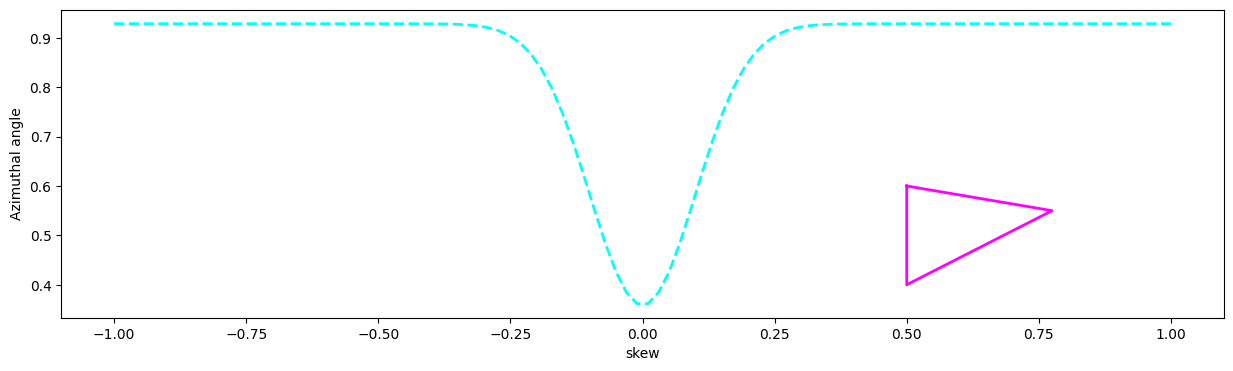

In [109]:
if plot_cluster_1:
   

    fig = plt.figure(figsize=(15, 4), dpi=100)
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[0, 0])

    x_vals = [v[2] for v in vectors]
    y_vals = [v[3] for v in vectors]

    ax.set_xlabel("skew")
    ax.set_ylabel("Azimuthal angle")

    ax.scatter(x_vals, y_vals, color="red", s=1)

    a = 0.1
    s = 7
    t = 6.5
    x_func = np.linspace(-1, 1, 100)
    y_func = (t - (1 / np.sqrt(2 * np.pi * a**2)) * np.exp(-((x_func)**2) / (2 * a**2))) / s

    ax.plot(x_func, y_func, color='cyan', linestyle='--', linewidth=2, label="gauss")

    triangle_x = [0.5, 0.775, 0.5, 0.5]
    triangle_y = [0.6, 0.55, 0.4, 0.6]

    ax.plot(triangle_x, triangle_y, color='magenta', linestyle='-', linewidth=2, label="Triangle")



    plt.show()

In [110]:
if plot_cluster_2:
    x = [v[1] for v in vectors]
    y = [v[2] for v in vectors]
    z = [v[3] for v in vectors]
    c = [v[0] for v in vectors]

    ds_f = 5

    x = x[::ds_f]
    y = y[::ds_f]
    z = z[::ds_f]
    c = c[::ds_f]


    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=1.3, color=c, opacity=1),
    )])

    fig.update_layout(
        title="3D Scatter of Vectors",
        scene=dict(
            xaxis_title="mean",
            yaxis_title="skew",
            zaxis_title="azimuthal angle",
            camera=dict(projection=dict(type="orthographic"))
        ),
        width=1200,
        height=600
    )

    fig.show()

In [111]:
stop #only add vectors once the vector space has been normalized (correct window_height)

NameError: name 'stop' is not defined

In [ ]:
#add vectors to csv
file_path = 'distribution_vectors.csv'

with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    for value in vectors:
        writer.writerow([value])

In [ ]:
#filter out repeated vectors 
import ast

with open('distribution_vectors.csv', 'r') as file:
    data = file.read()

vectors = [ast.literal_eval(vec) for vec in data.strip().split('"') if vec.strip()]
vectors = np.array(vectors)
print(vectors.shape)
unique_vectors = np.unique(vectors, axis = 0)
print(unique_vectors.shape)

with open('distribution_vectors.csv', 'w') as file:
    for vec in unique_vectors:
        file.write(f'"{list(vec)}"\n')
